In [1]:
# Import the all needed libraies
import os
import time
import cv2
from PIL import Image
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
os.environ["TFHUB_DOWNLOAD_PROGRESS"] = "True"

In [3]:
# Declaring Constants
IMAGE_PATH = "original.png"
SAVED_MODEL_PATH = "https://tfhub.dev/captain-pool/esrgan-tf2/1"

In [4]:
# Declaring the user-defined function for the preprocessing of the image
def preprocess_image(image_path):
  """ Loads image from path and preprocesses to make it model ready
      Args:
        image_path: Path to the image file
  """
  hr_image = tf.image.decode_image(tf.io.read_file(image_path))
  # If PNG, remove the alpha channel. The model only supports
  # images with 3 color channels.
  if hr_image.shape[-1] == 4:
    hr_image = hr_image[...,:-1]
  hr_size = (tf.convert_to_tensor(hr_image.shape[:-1]) // 4) * 4
  hr_image = tf.image.crop_to_bounding_box(hr_image, 0, 0, hr_size[0], hr_size[1])
  hr_image = tf.cast(hr_image, tf.float32)
  return tf.expand_dims(hr_image, 0)

In [5]:
# Declaring the user-defined function for the saving the image

def save_image(image, filename):
  """
    Saves unscaled Tensor Images.
    Args:
      image: 3D image tensor. [height, width, channels]
      filename: Name of the file to save.
  """
  if not isinstance(image, Image.Image):
    image = tf.clip_by_value(image, 0, 255)
    image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  image.save("%s.jpg" % filename)
  print("Saved as %s.jpg" % filename)

In [6]:
%matplotlib inline
# Declaring the user-defined function for the ploting the image

def plot_image(image, title=""):
  """
    Plots images from image tensors.
    Args:
      image: 3D image tensor. [height, width, channels].
      title: Title to display in the plot.
  """
  image = np.asarray(image)
  image = tf.clip_by_value(image, 0, 255)
  image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  plt.imshow(image)
  plt.axis("off")
  plt.title(title)

In [7]:
# Precess the given original image
hr_image = preprocess_image(IMAGE_PATH)

Saved as Original Image.jpg


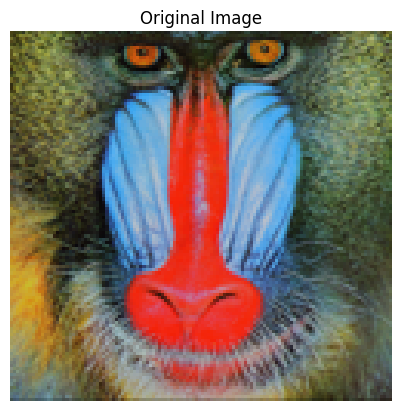

In [8]:
# Plotting Original Resolution image
plot_image(tf.squeeze(hr_image), title="Original Image")
save_image(tf.squeeze(hr_image), filename="Original Image")

In [9]:
# Save the given image as a Original image
original_image = cv2.imread("original.png")

In [10]:
# Find the shape of the given image
original_image.shape

(120, 125, 3)

In [11]:
# Download the Model and save it
model = hub.load(SAVED_MODEL_PATH)

Downloaded https://tfhub.dev/captain-pool/esrgan-tf2/1, Total size: 20.60MB



In [12]:
# Run the model with the original image
# Using the time function read the time taken to do the process
start = time.time()
fake_image = model(hr_image)
fake_image = tf.squeeze(fake_image)
print("Time Taken: %f" % (time.time() - start))

Time Taken: 9.386869


Saved as Super Resolution.jpg


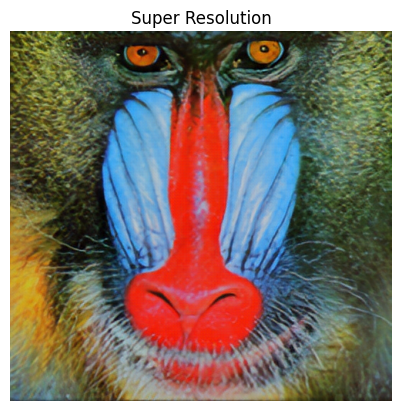

In [13]:
# Plotting Super Resolution Image
plot_image(tf.squeeze(fake_image), title="Super Resolution")
save_image(tf.squeeze(fake_image), filename="Super Resolution")

In [14]:
# Save the upscaled image
upscaled_image = cv2.imread('/content/Super Resolution.jpg')

In [15]:
# Find the shape of the upscaled image
upscaled_image.shape

(480, 496, 3)

In [63]:
# Declaring the user-defined function for the sharpening the image

def unsharp_mask(image, kernel_size=(5, 5), sigma=1.0, amount=1.0, threshold=0):
    """Return a sharpened version of the image, using an unsharp mask."""
    blurred = cv2.GaussianBlur(image, kernel_size, sigma)
    sharpened = float(amount + 1) * image - float(amount) * blurred
    sharpened = np.maximum(sharpened, np.zeros(sharpened.shape))
    sharpened = np.minimum(sharpened, 255 * np.ones(sharpened.shape))
    sharpened = sharpened.round().astype(np.uint8)
    if threshold > 0:
        low_contrast_mask = np.absolute(image - blurred) < threshold
        np.copyto(sharpened, image, where=low_contrast_mask)
    return sharpened



In [64]:
# Call the function for the sharpening the image
sharpened_image = unsharp_mask(upscaled_image)


In [65]:
# Save the image after the sharpening the image
cv2.imwrite('original_final_image.jpg', sharpened_image)

True

In [24]:
# Upload the test image
IMAGE_PATH = "test.png"

In [25]:
# Save the test image
test_image=cv2.imread("test.png")

In [26]:
# Find the shape of the test image
test_image.shape

(512, 512, 3)

In [27]:
# Defining helper functions for the downscaling the test image
def downscale_image(image):
  """
      Scales down images using bicubic downsampling.
      Args:
          image: 3D or 4D tensor of preprocessed image
  """
  image_size = []
  if len(image.shape) == 3:
    image_size = [image.shape[1], image.shape[0]]
  else:
    raise ValueError("Dimension mismatch. Can work only on single image.")

  image = tf.squeeze(
      tf.cast(
          tf.clip_by_value(image, 0, 255), tf.uint8))

  lr_image = np.asarray(
    Image.fromarray(image.numpy())
    .resize([image_size[0] // 4, image_size[1] // 4],
              Image.BICUBIC))

  lr_image = tf.expand_dims(lr_image, 0)
  lr_image = tf.cast(lr_image, tf.float32)
  return lr_image

In [28]:
# Preprocess the given test image
hr_image = preprocess_image(IMAGE_PATH)

In [29]:
# After the preprocessing downscaling the test image
lr_image = downscale_image(tf.squeeze(hr_image))

Saved as Low Resolution.jpg


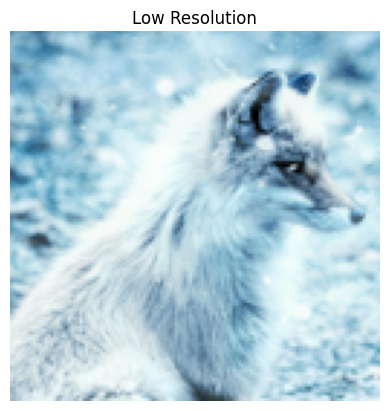

In [30]:
# Plotting Low Resolution Image
plot_image(tf.squeeze(lr_image), title="Low Resolution")
save_image(tf.squeeze(lr_image), filename="Low Resolution")

In [31]:
# Save the downscaled test image
test_low_res_image=cv2.imread("/content/Low Resolution.jpg")

In [32]:
# Find the shape of the downscaled test image
test_low_res_image.shape

(128, 128, 3)

In [33]:
# Load the model
model = hub.load(SAVED_MODEL_PATH)

In [34]:
# Run the model with the original image
# Using the time function read the time taken to do the process
start = time.time()
fake_image = model(lr_image)
fake_image = tf.squeeze(fake_image)
print("Time Taken: %f" % (time.time() - start))

Time Taken: 5.841659


PSNR Achieved: 28.029171
Saved as downscaled Resolution01.jpg


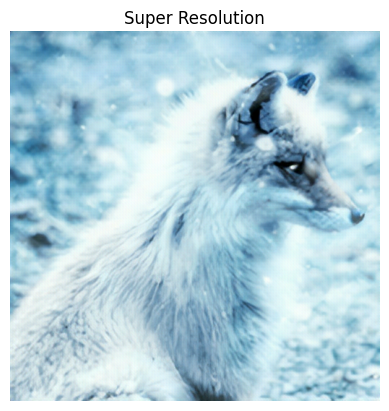

In [35]:
plot_image(tf.squeeze(fake_image), title="Super Resolution")
# Calculating PSNR wrt Original Image
psnr = tf.image.psnr(
    tf.clip_by_value(fake_image, 0, 255),
    tf.clip_by_value(hr_image, 0, 255), max_val=255)
print("PSNR Achieved: %f" % psnr)
save_image(tf.squeeze(fake_image), filename="downscaled Resolution01")

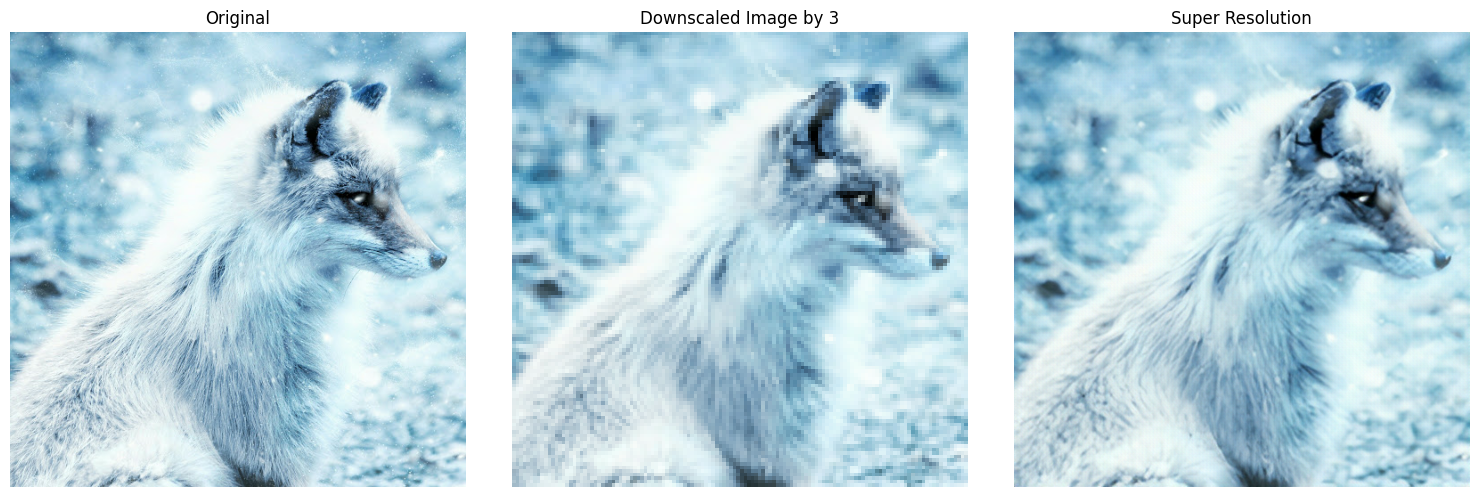

In [69]:
#Comparing Outputs size by side.
plt.rcParams['figure.figsize'] = [15, 10]
fig, axes = plt.subplots(1,3)
fig.tight_layout()
plt.subplot(131)
plot_image(tf.squeeze(hr_image), title="Original")   # Original image

plt.subplot(132)
fig.tight_layout()
# Downscaled test image by resize value as 4
plot_image(tf.squeeze(lr_image), "Downscaled Image by 4")

plt.subplot(133)
fig.tight_layout()
plot_image(tf.squeeze(fake_image), "Super Resolution")  # Super Resolution test image
plt.savefig("ESRGAN_DIV2K.jpg", bbox_inches="tight")


In [39]:
# Save the super resolution test image
test_upscaled_image=cv2.imread("/content/downscaled Resolution01.jpg")

In [40]:
# Find the shape of the Super Resolution test image
test_upscaled_image.shape

(512, 512, 3)

In [70]:
# using the user-defined function sharpening the image
sharpened_edge_image = unsharp_mask(test_upscaled_image)


In [71]:
# Save the sharped test image
cv2.imwrite('sharpened_edge_image.jpg', sharpened_edge_image)


True

In [45]:
#PSNR - Peak Signal-to-Noise Ratio
print("PSNR: %f" % psnr)

PSNR: 28.029171
